In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident'].replace({2: 'sans_urgence', 3: 'urgence', 4: 'sans_urgence'})
df['gravité_accident'].value_counts()

Mounted at /content/drive


,count
gravité_accident,
sans_urgence,190997
urgence,82229


Import des bibliothèques nécessaires

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV


Random Forest

Accuracy du modèle : 0.72
Précision : 0.70
Rappel : 0.72
F1-score : 0.70

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.77      0.86      0.81     38246
     urgence       0.54      0.39      0.45     16400

    accuracy                           0.72     54646
   macro avg       0.65      0.62      0.63     54646
weighted avg       0.70      0.72      0.70     54646



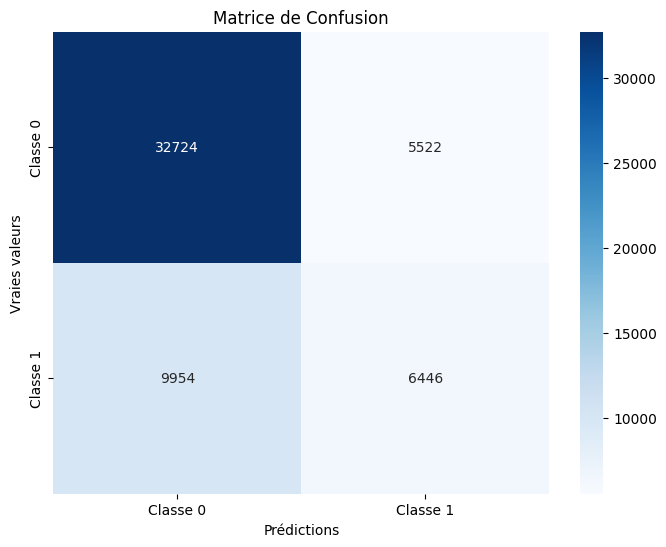

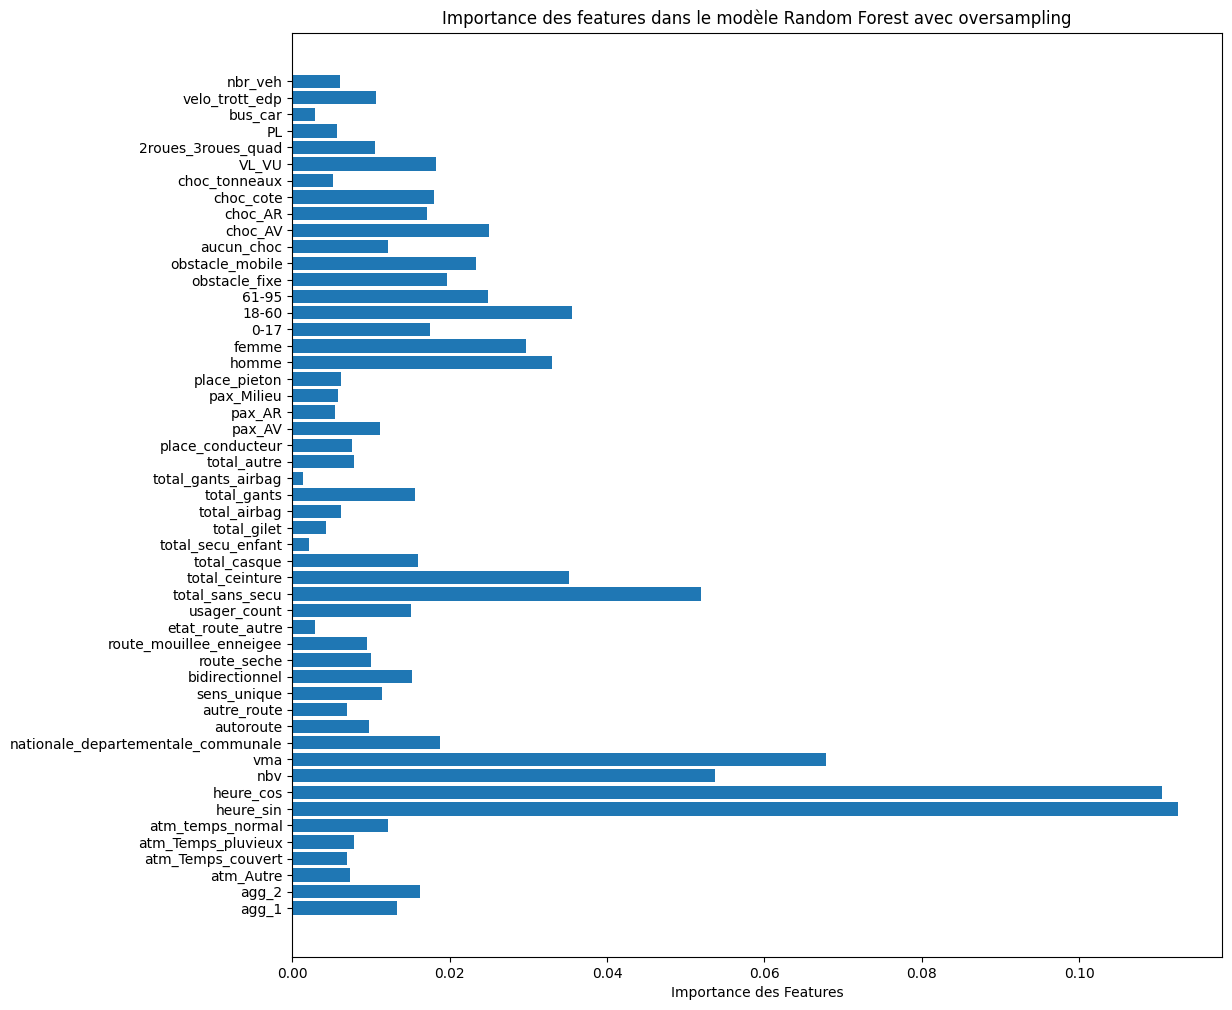

In [ ]:
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec les variables les plus importantes: vma, nbv, heure, total_sans_secu, nationale_communale_departementale

Accuracy du modèle : 0.72
Précision : 0.70
Rappel : 0.72
F1-score : 0.70

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.76      0.88      0.82     38246
     urgence       0.56      0.36      0.44     16400

    accuracy                           0.72     54646
   macro avg       0.66      0.62      0.63     54646
weighted avg       0.70      0.72      0.70     54646



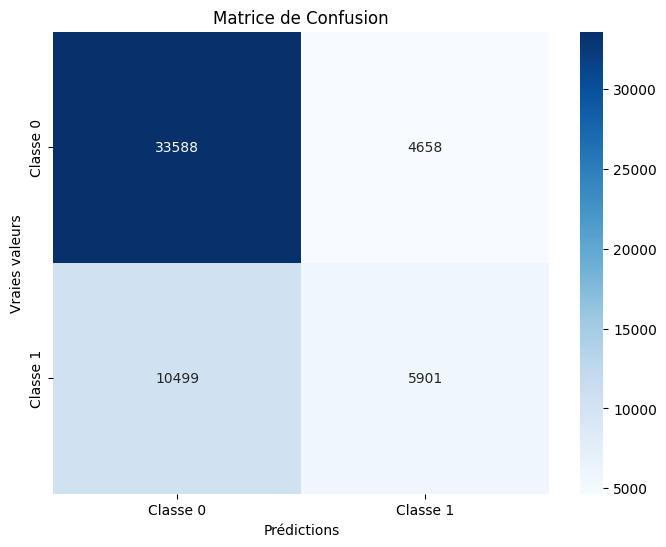

In [ ]:
# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale',
       'total_sans_secu']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()




Random Forest avec oversampling


Accuracy du modèle avec oversampling : 0.71
Accuracy du modèle : 0.71
Précision : 0.70
Rappel : 0.71
F1-score : 0.71

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.78      0.83      0.80     38246
     urgence       0.53      0.44      0.48     16400

    accuracy                           0.71     54646
   macro avg       0.65      0.63      0.64     54646
weighted avg       0.70      0.71      0.71     54646



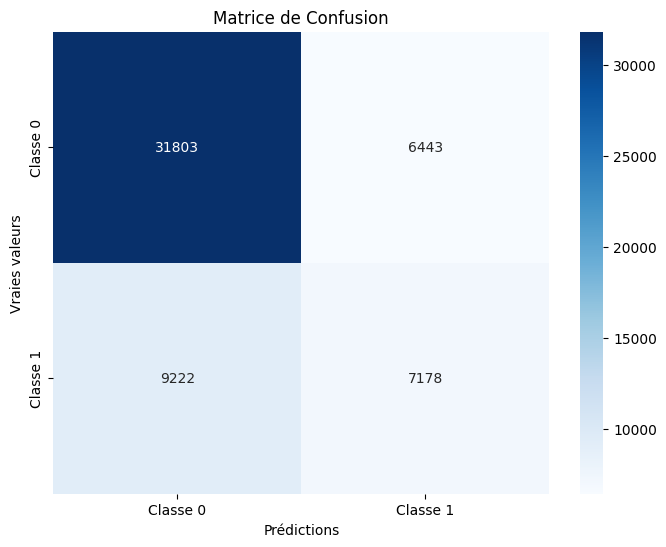

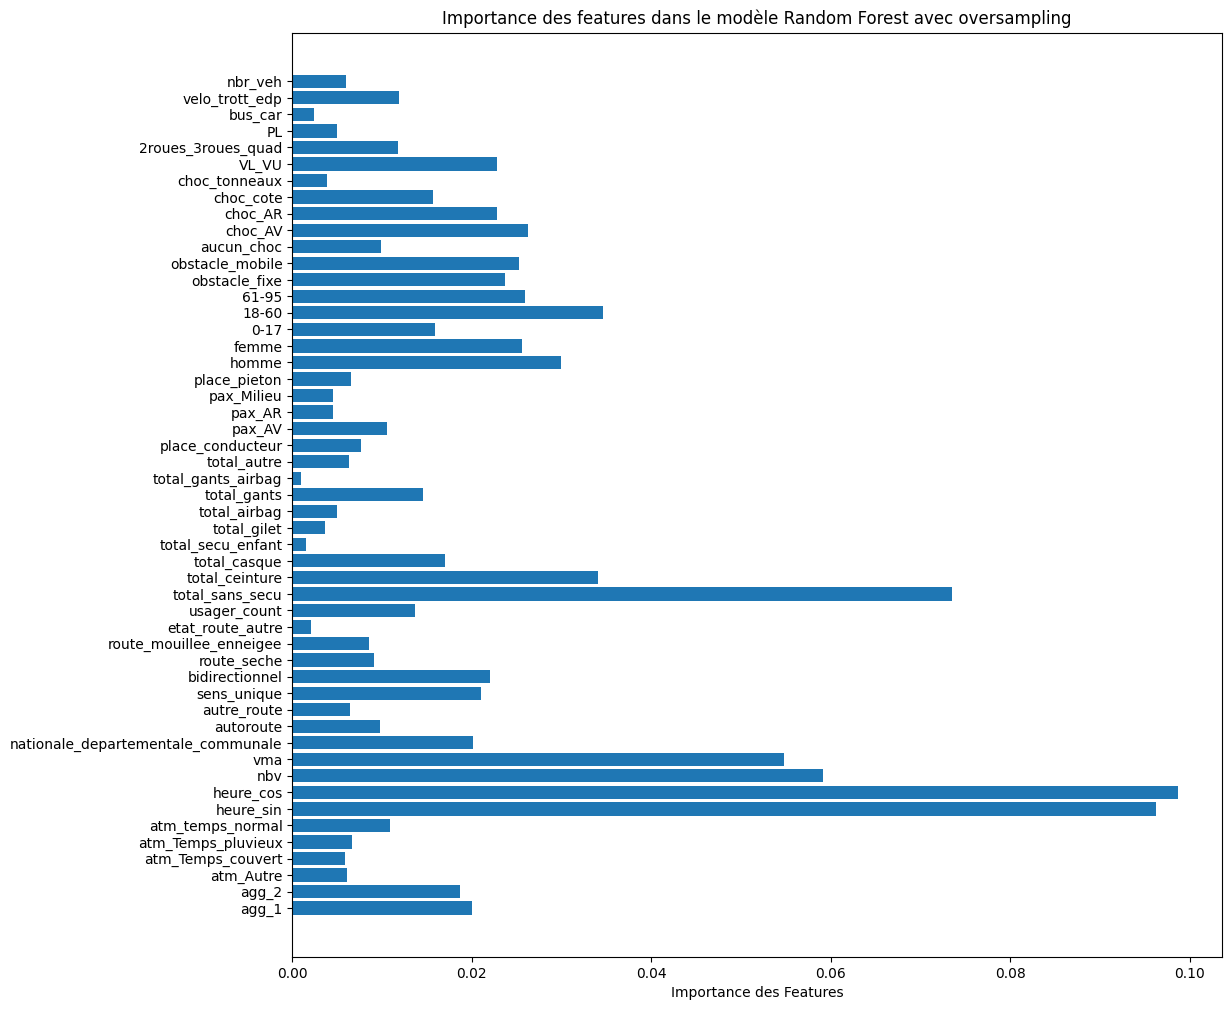

In [ ]:
# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer SMOTE dans la pipeline (avant l'entraînement du modèle)
smote = SMOTE(random_state=42, sampling_strategy = 'auto', k_neighbors = 5)

# Définir la pipeline complète avec SMOTE
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('smote', smote),  # Oversampling via SMOTE
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec oversampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec oversampling : {accuracy:.2f}")

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")



# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec Undersampling

Accuracy du modèle avec undersampling : 0.67
Précision : 0.72
Rappel : 0.67
F1-score : 0.69

Rapport de Classification :
              precision    recall  f1-score   support

sans_urgence       0.83      0.67      0.74     38246
     urgence       0.47      0.67      0.55     16400

    accuracy                           0.67     54646
   macro avg       0.65      0.67      0.65     54646
weighted avg       0.72      0.67      0.69     54646



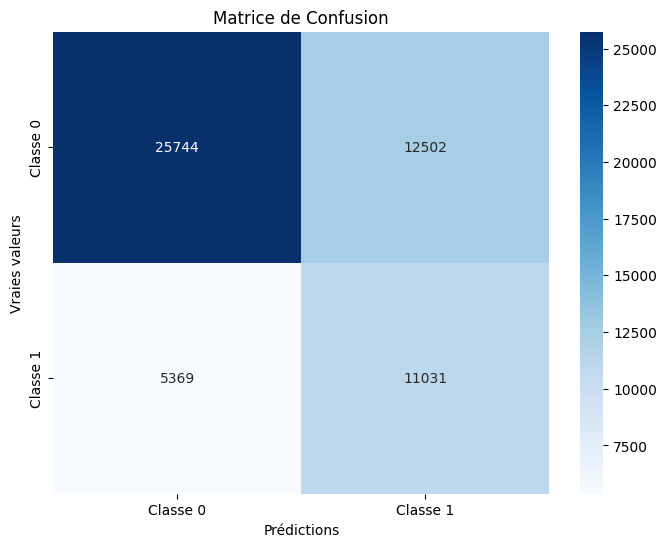

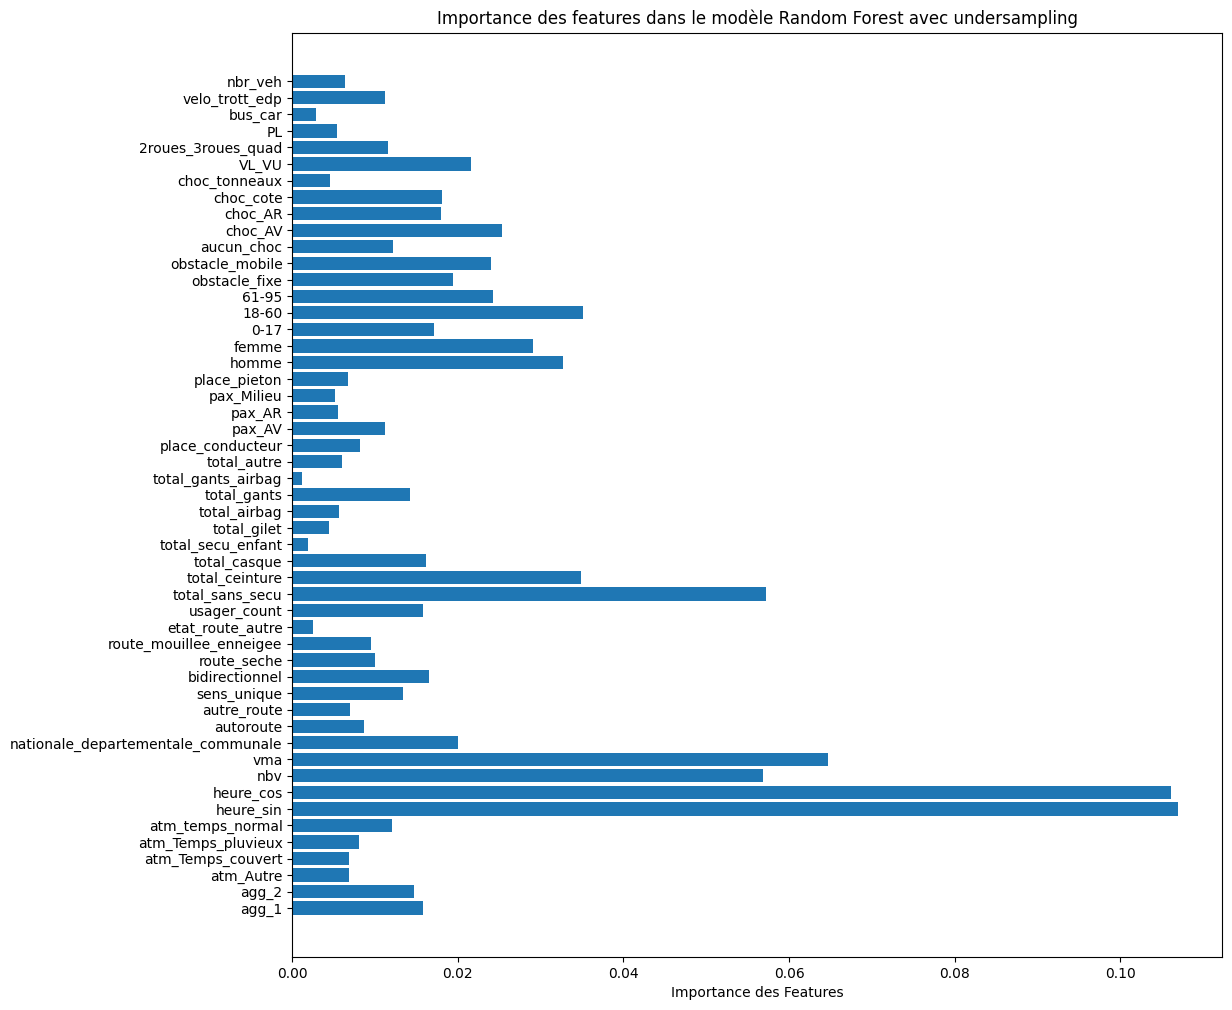

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer RandomUnderSampler dans la pipeline (avant l'entraînement du modèle)
under_sampler = RandomUnderSampler(random_state=42)

# Définir la pipeline complète avec undersampling
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('under_sampler', under_sampler),  # Undersampling via RandomUnderSampler
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec undersampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec undersampling")
plt.show()

Grrid search pour optimiser paramètres du modele avec toutes les variables. Utilisation de class_weight='balanced' pour gérer le déséquilibre des classes

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__n_estimators': 200}

📊 **Performance du modèle optimal**
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1-score: 0.73

Rapport de Classification:
              precision    recall  f1-score   support

sans_urgence       0.82      0.77      0.80     38246
     urgence       0.53      0.60      0.56     16400

    accuracy                           0.72     54646
   macro avg       0.67      0.69      0.68     54646
weighted avg       0.73      0.72      0.73     54646



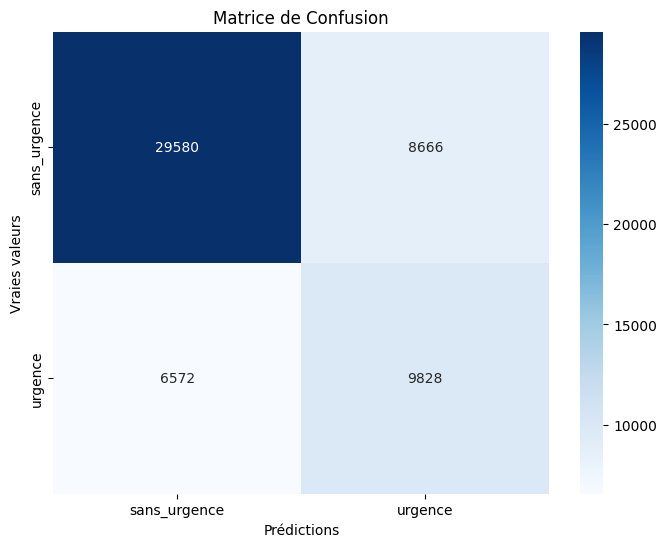

In [ ]:
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42,class_weight='balanced')

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()



GridSearch avec les variables les plus importantes pour optimiser les paramètres du modèle

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

📊 **Performance du modèle optimal**
Accuracy: 0.73
Precision: 0.71
Recall: 0.73
F1-score: 0.70

Rapport de Classification:
              precision    recall  f1-score   support

sans_urgence       0.76      0.90      0.82     38246
     urgence       0.58      0.34      0.43     16400

    accuracy                           0.73     54646
   macro avg       0.67      0.62      0.62     54646
weighted avg       0.71      0.73      0.70     54646



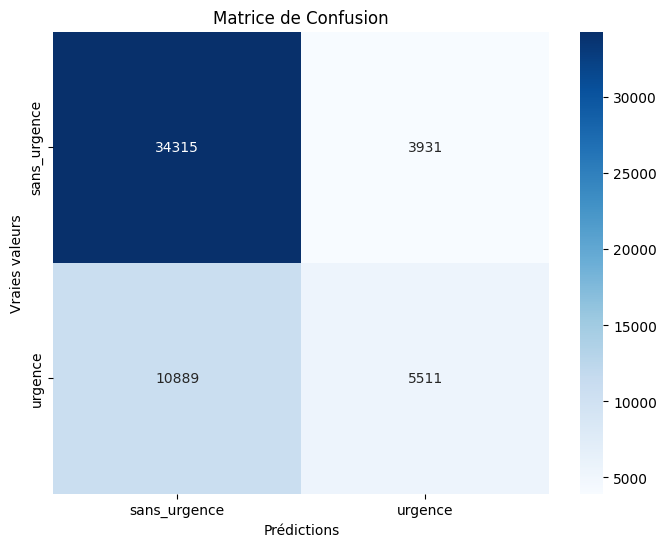

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 📌 **Définition des variables**
categorical_features = ['agg']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma']

# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42)

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

Random Forest avec métrique pondérée pour optimiser le Recall

Configuration des poids {0: 1, 1: 2} -> Précision pondérée : 0.5588953910759638
Configuration des poids {0: 1, 1: 3} -> Précision pondérée : 0.5254302035131241
Configuration des poids {0: 1, 1: 5} -> Précision pondérée : 0.4919650159502845
Configuration des poids {0: 1, 1: 10} -> Précision pondérée : 0.4615421181658849

Meilleure configuration de pondération : {0: 1, 1: 2}

📊 **Performance du modèle optimal**
Accuracy: 0.72
Precision: 0.73
Recall_optimal: 0.72
F1-score:  0.72

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     38246
           1       0.53      0.60      0.56     16400

    accuracy                           0.72     54646
   macro avg       0.67      0.69      0.68     54646
weighted avg       0.73      0.72      0.72     54646



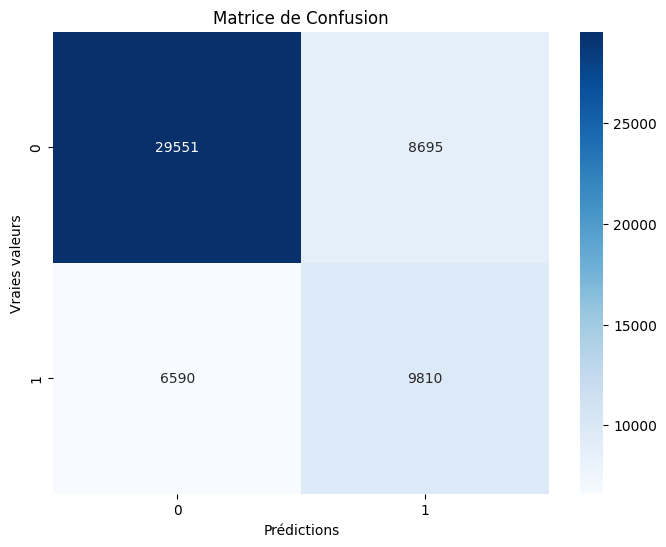

In [ ]:
from sklearn.metrics import recall_score

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')


# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

from sklearn.preprocessing import LabelEncoder

# Encoder les labels en entiers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['gravité_accident'])

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre', 'place_conducteur',
                        'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux',
                        'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Définir les différentes pondérations à tester (déjà définies dans ton code précédent)
class_weights_list = [
    {0: 1, 1: 2},
    {0: 1, 1: 3},
    {0: 1, 1: 5},
    {0: 1, 1: 10},
]

# Classe 0: sans_urgence
# Classe 1: urgence
# Définir une fonction pour la précision pondérée
def weighted_f1_score(y_true, y_pred, class_weights):
    # Calculer la précision pour chaque classe
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Associer les poids aux classes dans le même ordre que dans precision_per_class
    weights = [class_weights.get(i, 1) for i in range(len(f1_per_class))]

    # Calculer la précision pondérée en fonction des poids
    weighted_f1 = np.dot(f1_per_class, weights) / sum(weights)
    return weighted_f1


# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42))  # Classificateur
])

# Pour chaque configuration de poids, effectuer une validation croisée et calculer la précision pondérée
results = {}

for class_weights in class_weights_list:
    # Utiliser cross_val_score pour évaluer la performance avec les poids de classes
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=lambda est, X, y: weighted_f1_score(y, est.predict(X), class_weights)
    )

    # Enregistrer la moyenne des scores de précision pondérée
    results[str(class_weights)] = np.mean(f1_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results.items():
    print(f"Configuration des poids {class_weights} -> Précision pondérée : {score}")

# Trouver la configuration qui donne la meilleure précision pondérée
best_class_weights = max(results, key=results.get)
print(f"\nMeilleure configuration de pondération : {best_class_weights}")

# Créer la pipeline en utilisant les poids optimaux dans le classificateur RandomForest
pipeline_with_optimal_weights = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        class_weight=eval(best_class_weights) # Appliquer les poids ici
    ))
])

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Evaluation de la performance du modèle

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall_optimal = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall_optimal: {recall:.2f}")
print(f"F1-score: {f1_score: .2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

Grid search avec scoring personnalisé pour optimiser recall classe urgence

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__n_estimators': 50}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.73
Recall: 0.70
F1-score: 0.71

Rapport de Classification:
              precision    recall  f1-score   support

sans_urgence       0.83      0.73      0.78     38246
     urgence       0.51      0.65      0.57     16400

    accuracy                           0.70     54646
   macro avg       0.67      0.69      0.67     54646
weighted avg       0.73      0.70      0.71     54646



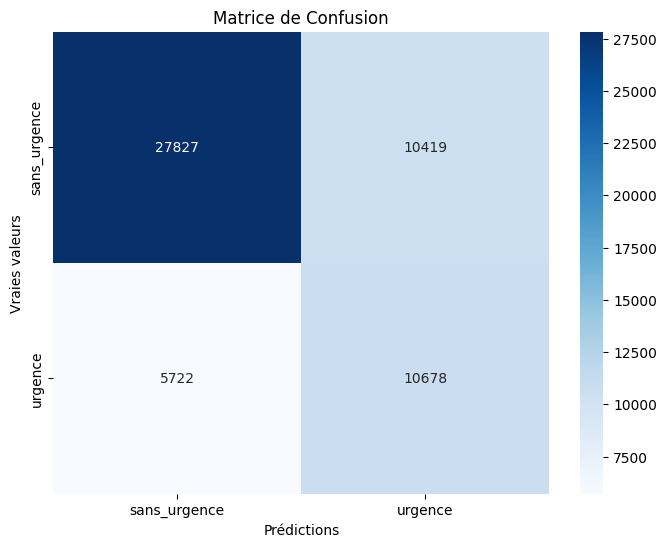

In [3]:
from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer X et y
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Définir un scorer personnalisé pour optimiser le recall de la classe 1 (hospitalisé)**
def class_specific_recall(y_true, y_pred, class_index=1):
    return recall_score(y_true, y_pred, labels=[class_index], average='micro')

# Crée un scorer personnalisé basé sur le recall pour la classe 1
custom_recall_scorer = make_scorer(class_specific_recall, class_index=1)


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')


# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])


# 📌 **Définition de la grille de recherche**
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}

# 📌 **Lancer la GridSearchCV avec le scorer personnalisé**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=custom_recall_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


Grid search avec scoring personnalisé pour optimiser F1_score classe urgence

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__n_estimators': 50}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.73
Recall: 0.70
F1-score: 0.71

Rapport de Classification:
              precision    recall  f1-score   support

sans_urgence       0.83      0.73      0.78     38246
     urgence       0.51      0.65      0.57     16400

    accuracy                           0.70     54646
   macro avg       0.67      0.69      0.67     54646
weighted avg       0.73      0.70      0.71     54646



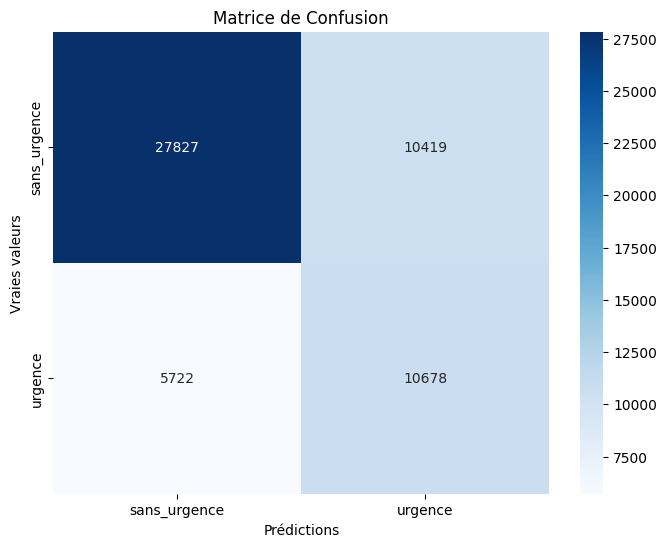

In [4]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer X et y
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Définir un scorer personnalisé pour optimiser le F1-score de la classe 1 (hospitalisé)**
def class_specific_f1(y_true, y_pred, class_index=1):
    return f1_score(y_true, y_pred, labels=[class_index], average='micro')

# Crée un scorer personnalisé basé sur le F1-score pour la classe 1
custom_f1_scorer = make_scorer(class_specific_f1, class_index=1)


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')


# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])


# 📌 **Définition de la grille de recherche**
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}

# 📌 **Lancer la GridSearchCV avec le scorer personnalisé**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=custom_f1_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()
